In [1]:
!uv pip install jupyterlab-vim

Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Audited 1 package in 11ms


In [1]:
## juperlab is annoying if you dont have the correct working version
!uv pip list | grep jupyterlab

jupyterlab                4.5.0a0
jupyterlab-pygments       0.3.0
jupyterlab-server         2.27.3
jupyterlab-widgets        3.0.15


Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv


In [2]:
!uv pip list | grep fastplotlib

fastplotlib               0.5.0


Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv


In [1]:
%matplotlib inline
%load_ext autoreload
   
from pathlib import Path
import fastplotlib as fpl
import os
import sys
import masknmf
import tifffile
import torch
import numpy as np

import matplotlib.pyplot as plt
import time

Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [39]:


raw_data = tifffile.memmap(r"D:\demo\masknmf\assembled\roi_1\plane_07.tif")
raw_data = raw_data[:-200, ...]

tifffile.imwrite("./plane_07.tif", raw_data)

In [ ]:
mean_sub = raw_data - raw_data.mean(axis=0)
raw_data.shape, mean_sub.shape

((2135, 448, 224), (2135, 448, 224))

In [37]:
raw_data.shape

(2135, 448, 224)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
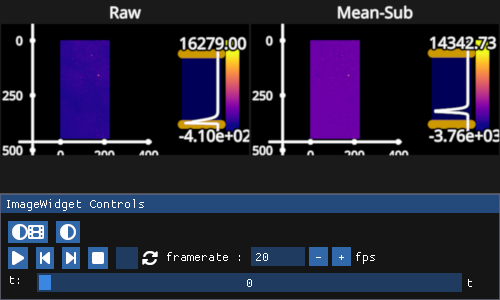

In [8]:
iw = fpl.ImageWidget(data=[raw_data, mean_sub], names=["Raw", "Mean-Sub"], figure_shape=(1, 2))
iw.show()

In [9]:
iw.close()

In [10]:
pixel_weighting = torch.from_numpy(np.std(raw_data, axis = 0))

In [12]:
rigid_strategy = masknmf.RigidMotionCorrection(
    max_shifts = [5, 5]
)
pwrigid_strategy = masknmf.PiecewiseRigidMotionCorrection(
    num_blocks = [32, 32], 
    overlaps = [5, 5],
    max_rigid_shifts = [5, 5],
    max_deviation_rigid = [2, 2]
)

pwrigid_strategy = masknmf.motion_correction.compute_template(
    raw_data,
    rigid_strategy,
    num_iterations_piecewise_rigid = 1,
    pwrigid_strategy = pwrigid_strategy,
    device = "cuda", 
    batch_size = 1000
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


## TODO: Save moco_results so if you need to restart kernel you can reload them

In [13]:
moco_results = masknmf.RegistrationArray(raw_data, pwrigid_strategy, device = "cuda")

In [14]:
dense_moco = moco_results[:]
mean_sub_dense = dense_moco - np.mean(dense_moco, axis=0)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
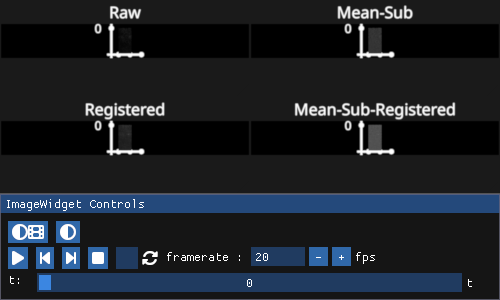

In [36]:
iw = fpl.ImageWidget(
    data = [raw_data, mean_sub, dense_moco, mean_sub_dense],
    names = ['Raw', 'Mean-Sub', 'Registered', 'Mean-Sub-Registered'],
    figure_shape=(2,2),
    # figure_kwargs={"size": (894, 448)},
    histogram_widget=False,
    cmap="gray",
)
iw.show()

In [ ]:
iw.close()

In [ ]:
np.savez("pmd_reg_subfov.npz", pmd_obj)

In [31]:
pmd_obj_s2p = masknmf.compression.pmd_decomposition(
    data_reg, [32, 32],
    data_reg.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

pmd_obj_nmf = masknmf.compression.pmd_decomposition(
    dense_moco, [32, 32],
    dense_moco.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

[25-05-14 14:02:43]: Starting compression
[25-05-14 14:02:43]: sampled from the following regions: [0]
[25-05-14 14:02:43]: We are initializing on a total of 903 frames
[25-05-14 14:02:44]: Approximating full FOV basis terms
[25-05-14 14:02:44]: Loading data to estimate complete spatial basis
[25-05-14 14:02:44]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 191.93it/s]

[25-05-14 14:02:45]: Running Blockwise Decompositions


[25-05-14 14:02:48]: Constructed U matrix. Rank of U is 2101
[25-05-14 14:02:48]: PMD Objected constructed
[25-05-14 14:02:48]: Starting compression
[25-05-14 14:02:48]: sampled from the following regions: [0]
[25-05-14 14:02:48]: We are initializing on a total of 903 frames
[25-05-14 14:02:49]: Approximating full FOV basis terms
[25-05-14 14:02:49]: Loading data to estimate complete spatial basis
[25-05-14 14:02:49]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 200.07it/s]

[25-05-14 14:02:50]: Running Blockwise Decompositions


[25-05-14 14:02:53]: Constructed U matrix. Rank of U is 2179
[25-05-14 14:02:53]: PMD Objected constructed


RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
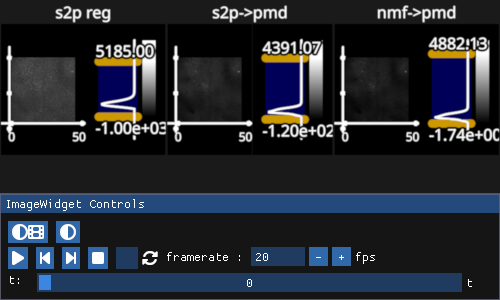

Draw error: Validation Error (6)


In [33]:
iw = fpl.ImageWidget(
    data = [data_reg, pmd_obj_s2p, pmd_obj_nmf],
    names = ['s2p reg', 's2p->pmd', 'nmf->pmd'],
    figure_shape=(1,3),
    cmap="gray",
)
iw.show()

In [34]:
iw.close()

In [35]:
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_obj_nmf,
    device=device,
    frame_batch_size=100
)

Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


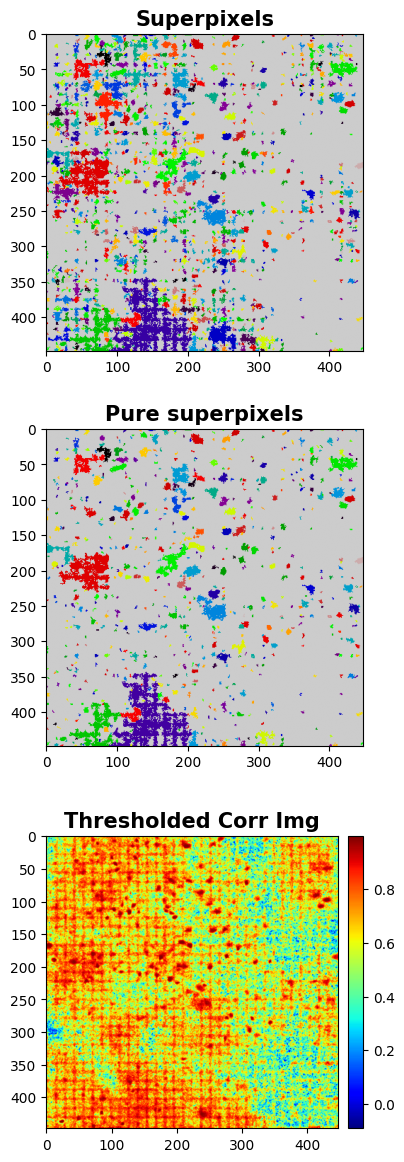

Identified 711 neurons here


In [36]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

## Increasing pmd block size 32x32 -> 64x64

[25-05-14 14:42:04]: Starting compression
[25-05-14 14:42:04]: sampled from the following regions: [0]
[25-05-14 14:42:04]: We are initializing on a total of 903 frames
[25-05-14 14:42:04]: Approximating full FOV basis terms
[25-05-14 14:42:04]: Loading data to estimate complete spatial basis
[25-05-14 14:42:05]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 344.59it/s]

[25-05-14 14:42:05]: Running Blockwise Decompositions


[25-05-14 14:42:09]: Constructed U matrix. Rank of U is 2213
[25-05-14 14:42:09]: PMD Objected constructed
Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


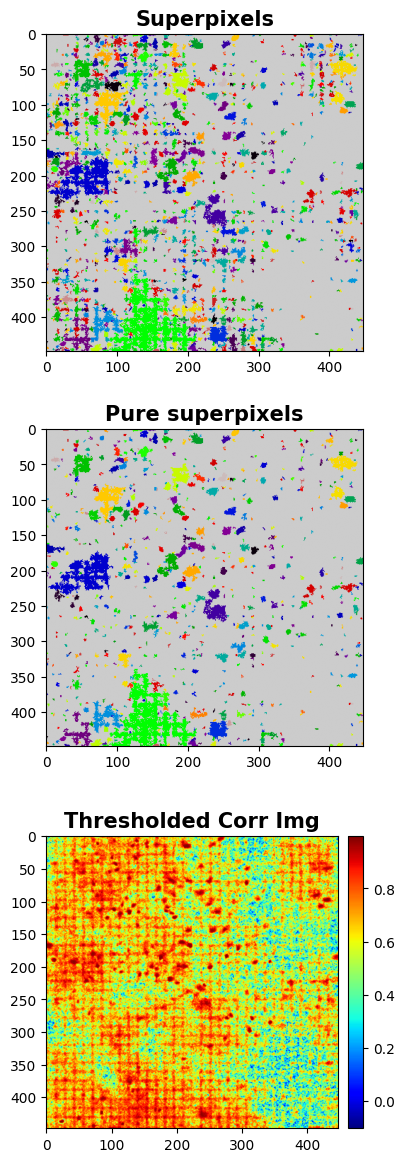

Identified 722 neurons here


In [49]:
pmd_obj_nmf = masknmf.compression.pmd_decomposition(
    dense_moco, [32, 32],
    dense_moco.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cuda"
)

num_frames, fov_dim1, fov_dim2 = pmd_obj_nmf.shape
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_obj_nmf,
    device=device,
    frame_batch_size=100
)

init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")


In [50]:
print(pmd_demixer.state.state_description)

Initialization state: identify initial estimates of the signals present in the data


In [51]:
pmd_demixer.lock_results_and_continue()

Now in demixing state


In [52]:
## Demixing State

num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [30:02<00:00, 72.09s/it]


that took 1804.2344808578491
after this step 722 signals identified


RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
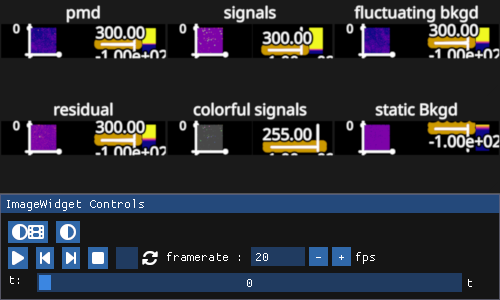

Draw error: Validation Error (7)


In [53]:
# If desired, you can view the demixing results at this stage
iw = masknmf.visualization.make_demixing_video(
    pmd_demixer.results,
    device,
    show_histogram = True,
    v_range = [-100, 300],
)

iw.show()

In [54]:
iw.close()

In [55]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in the initialization state


In [56]:
print(pmd_demixer.state.state_description)

Initialization state: identify initial estimates of the signals present in the data


Computing correlation data structure with MAD threshold  0and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


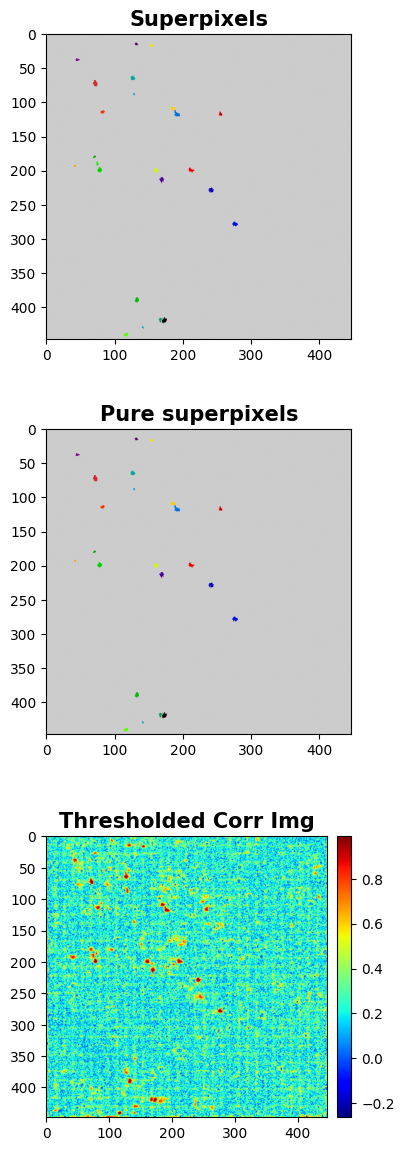

Identified 745 neurons here


In [57]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.9,
    'min_superpixel_size':5,
    'robust_corr_term':1,

    #Mostly stable
    'mad_threshold':0,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [58]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in demixing state


In [59]:
## Demixing State
num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [30:09<00:00, 72.40s/it]


that took 1811.8009195327759
after this step 745 signals identified


In [60]:
a = pmd_demixer.results.ac_array.export_a()
c = pmd_demixer.results.ac_array.export_c()

#"a" is a fov dim1 x fov dim2 x number of neurons numpy.ndarray
#"c" is a num_frames x num_neurons np.ndarray

In [26]:
res = np.load(Path(r"D:\W2_DATA\kbarber\2025_03_01\mk301\masknmf\roi_1\results\plane7\final.npy"), allow_pickle=True).item()

In [30]:
res.pmd_obj.rescale = True

RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
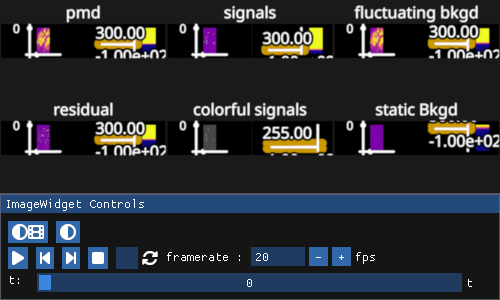

In [31]:
iw = masknmf.visualization.make_demixing_video(
    res.results,
    'cuda',
    show_histogram = True,
    v_range = [-100, 300],
)
iw.show()

In [32]:
iw.close()